In [59]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import datetime 
# import seaborn as sb
import pyproj
import matplotlib.cm as cm
from matplotlib import colors
from geopandas import gpd
from shapely.geometry import Point
from matplotlib.legend import Legend
import sys
import os
import geopandas
import fiona
import matplotlib.patches as mpatches
from geopandas import GeoDataFrame

import pickle

from tqdm import tqdm
tqdm.pandas()

In [60]:
# os.listdir("USA_Census_Tract_Boundaries")

## Importing US census tract data

gdf = gpd.read_file("USA_Census_Tract_Boundaries/v10/tracts.gdb", driver='FileGDB', layer='tracts')
gdf["STATE_FIPS"] = gdf["STATE_FIPS"].apply(int)

## Removing all islands and non-mainland states and territories
gdf = gdf[(gdf["STATE_FIPS"] <= 56) &
          (gdf["STATE_FIPS"] != 44) &
          (gdf["STATE_FIPS"] != 15) &
          (gdf["STATE_FIPS"] != 2)]


## Projecting to US Albers conic equal-area projection
gdf = gdf.to_crs("ESRI:102003")

In [62]:
## Importing US planning areas
gdf_planning_areas = gpd.read_file("DHS/Electric_Planning_Areas.gdb", driver='FileGDB', layer='Planning_Areas')

## Dropping islands and non-mainland states and territories
gdf_planning_areas = gdf_planning_areas.drop([92, 68])

## Projecting to US Albers conic equal-area projection
gdf_planning_areas = gdf_planning_areas.to_crs("ESRI:102003")

In [63]:
## Function to check whether buffering areas to create valid polygons is modifying it adversely or not
def check_buffer_areas(gdf, geom_column="geometry", tolerance_fraction=1e-4, buffer_limit=0):
    
    l_g = []
    for loc in tqdm(range(gdf.shape[0])):
        l_g.append(gdf.iloc[loc][geom_column].buffer(buffer_limit).area /
                   gdf.iloc[loc][geom_column].area)
        
    if len(l_g[(1 - tolerance_fraction > l_g) | (l_g > 1 + tolerance_fraction)]) == 0:
        print("No issues in using buffer to make valid polygons")
        
    else:
        print("Some buffered areas are outside tolerance values")
        
    return

In [64]:
## Function to validate all polygons
gdf["geometry"] = gdf["geometry"].progress_apply(lambda x: x.buffer(0))
gdf_planning_areas["geometry"] = gdf_planning_areas["geometry"].progress_apply(lambda x: x.buffer(0))

100%|██████████| 95/95 [00:31<00:00,  3.06it/s] 


## Use the cell below if you do not have the tracts_planning_areas_ratios.pkl file, otherwise skip

In [7]:
## Finds intersecting area for all the census tracts

def dict_areas(row, gdf_large, geom_col):
    area = gdf_large.intersection(row[geom_col]).area
    return area[area > 0].divide(row[geom_col].area).to_dict()

def create_df_area_intersection_ratio(gdf_small, gdf_large, output_col="ratios_of_areas",
                                      geom_large_col="geometry", geom_small_col="geometry",
                                      gdf_large_col="ID", gdf_small_col="FIPS"):
    
    
    print("Running area intersection calculation")
    gdf_small[output_col] = (gdf_small.progress_apply(lambda x: dict_areas(x, gdf_large.set_index(gdf_large_col),
                                                                 geom_large_col), axis=1))
    print("Area intersections calculated")
    return gdf_small

gdf_tracts_split = create_df_area_intersection_ratio(gdf, gdf_planning_areas)

## save pickle file with all the intersecting area ratios
f = open("tracts_planning_areas_ratios.pkl", "wb")
pickle.dump(gdf_tracts_split[["FIPS", "ratios_of_areas"]], f)
f.close()

  0%|          | 1/72042 [00:00<2:08:05,  9.37it/s]

Running area intersection calculation


100%|██████████| 72042/72042 [5:16:29<00:00,  3.79it/s]    

Area intersections calculated


In [13]:
## This code stack was being used earlier for area intersection but missed out on a few intersections

# def df_ids_contained(gdf_small, gdf_large, output_col="ratios_of_areas", geom_large_col="geometry",
#                      geom_small_col="geometry", gdf_large_col="ID", gdf_small_col="FIPS"):
    
#     gdf_tracts_contained = (geopandas.sjoin(gdf_small, gdf_large[[gdf_large_col, geom_large_col]],
#                                             how="inner", op="within")[[gdf_small_col, gdf_large_col]]
#                             .groupby(gdf_small_col).agg(list).reset_index())
    
#     gdf_tracts_contained[output_col] = gdf_tracts_contained[gdf_large_col].apply(lambda x: dict.fromkeys(x, 1.0))
#     gdf_tracts_contained.drop(gdf_large_col, axis=1, inplace=True)
#     return gdf_tracts_contained.sort_values(gdf_small_col)

# def dict_areas(row, gdf_large, geom_col):
#     area = gdf_large.intersection(row[geom_col]).area
#     return area[area > 0].divide(row[geom_col].area).to_dict()

# def create_df_area_intersection_ratio(gdf_small, gdf_large, output_col="ratios_of_areas",
#                                       geom_large_col="geometry", geom_small_col="geometry",
#                                       gdf_large_col="ID", gdf_small_col="FIPS"):
    
#     print("Running containment calculation")
#     df_tracts_contained = df_ids_contained(gdf_small, gdf_large, output_col, geom_large_col,
#                                            geom_small_col, gdf_large_col, gdf_small_col)
#     print("Tracts contained calculated")
    
#     tracts_within = list(df_tracts_contained[gdf_small_col])
#     tracts_not_within = gdf_small[~gdf_small[gdf_small_col].isin(tracts_within)][gdf_small_col]
#     gdf_partial_tracts = gdf_small[gdf_small[gdf_small_col].isin(tracts_not_within)]
    
#     print("Running area intersection calculation")
#     gdf_partial_tracts[output_col] = (gdf_partial_tracts
#                                       .progress_apply(lambda x: 
#                                                       dict_areas(x, gdf_large.set_index(gdf_large_col),
#                                                                  geom_large_col), axis=1))
#     print("Area intersections calculated")
    
#     gdf_tracts_split = pd.concat([df_tracts_contained, gdf_partial_tracts[[gdf_small_col, output_col]]])
#     return gdf_tracts_split

# gdf_tracts_split = create_df_area_intersection_ratio(gdf, gdf_planning_areas)

# f = open("gdf_tracts_ratios.pkl", "wb")
# pickle.dump(gdf_tracts_split, f)
# f.close()

## Use the cell below if you have the tracts_planning_areas_ratios.pkl file

In [65]:
f = open("tracts_planning_areas_ratios.pkl", "rb")
gdf_tracts_split = pickle.load(f)
f.close()

try:
    gdf = gdf.drop("ratios_of_areas", axis=1)
    
except:
    pass
    
gdf_tracts_split = gdf.merge(gdf_tracts_split[["FIPS", "ratios_of_areas"]])

In [67]:
gdf_tracts_split["num_poly"] = gdf_tracts_split["ratios_of_areas"].apply(lambda x: len(x))
gdf_tracts_split["area_sum"] = gdf_tracts_split["ratios_of_areas"].apply(lambda x: np.sum(list(x.values())))
gdf_tracts_split["intersecting_id"] = gdf_tracts_split["ratios_of_areas"].apply(lambda x: list(x.keys()))
gdf_tracts_split.head()

,STATE_FIPS,CNTY_FIPS,STCOFIPS,TRACT,FIPS,POPULATION,POP_SQMI,POP2010,POP10_SQMI,WHITE,...,OWNER_OCC,RENTER_OCC,SQMI,Shape_Length,Shape_Area,geometry,ratios_of_areas,num_poly,area_sum,intersecting_id
0,6,087,06087,120200,06087120200,4510.0,40.0,4283.0,37.9,3745.0,...,1121.0,550.0,112.87,0.981522,0.029627,"POLYGON ((-2275910.701 284048.054, -2275857.69...",{'2775': 0.9999970280860122},1,0.999997,[2775]
1,6,075,06075,980401,06075980401,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.16,0.073738,0.000043,"MULTIPOLYGON (((-2326717.163 355301.669, -2326...",{},0,0.000000,[]
2,6,081,06081,613800,06081613800,4249.0,23.3,4005.0,22.0,3140.0,...,956.0,646.0,182.03,1.357497,0.047898,"MULTIPOLYGON (((-2275910.701 284048.054, -2275...","{'25471': 0.0001347869738244602, '2775': 0.999...",2,0.999993,"[25471, 2775]"
3,6,081,06081,613700,06081613700,9585.0,220.2,8755.0,201.1,6563.0,...,2216.0,1032.0,43.53,0.646961,0.011481,"MULTIPOLYGON (((-2277634.884 319137.786, -2277...",{'2775': 0.9999336380114692},1,0.999934,[2775]
4,6,081,06081,613200,06081613200,6767.0,435.2,6494.0,417.6,5813.0,...,2104.0,458.0,15.55,0.384347,0.004098,"POLYGON ((-2270384.664 306925.597, -2270364.40...","{'25471': 0.0028103685536024943, '2775': 1.0}",2,1.002810,"[25471, 2775]"


In [52]:
## Planning area not involved in any of the census tracts
# set(gdf_planning_areas["ID"]) - set([item for sublist in
#                                      list(gdf_tracts_split["intersecting_id"])
#                                      for item in sublist])

In [68]:
## Makes 2-D Mapping of tracts and planning areas with intersecting area of every tract and planning area

def create_area_intersection_matrix(gdf_small, gdf_large, gdf_small_col="FIPS", gdf_large_col="ID",
                                    ratio_column="ratios_of_areas"):
    
    area_matrix = np.zeros((gdf_small.shape[0], gdf_large.shape[0]))

    tract_index_dict = dict(zip(sorted(list(gdf_small[gdf_small_col])), range(gdf_small.shape[0])))
    plan_area_index_dict = dict(zip(sorted(list(gdf_large[gdf_large_col])), range(gdf_large.shape[0])))

    tract_list = sorted(list(gdf_small[gdf_small_col]))
    plan_area_list = sorted(list(gdf_large[gdf_large_col]))

    for idx, row in gdf_small.iterrows():

        area_indexes = [plan_area_index_dict[a] for a in row[ratio_column].keys()]
        area_values = list(row[ratio_column].values())
        area_matrix[tract_index_dict[row[gdf_small_col]], area_indexes] = area_values
        
    return area_matrix, tract_list, plan_area_list

area_matrix, tract_list, plan_area_list = create_area_intersection_matrix(gdf_tracts_split, gdf_planning_areas)


In [69]:
## Normalized area and population matrix 

area_norm_matrix = area_matrix / area_matrix.sum(axis=1)[:, np.newaxis]
tract_population_vector = gdf_tracts_split.sort_values("FIPS")["POPULATION"].values

pop_norm_matrix = tract_population_vector[:, np.newaxis] * area_norm_matrix
pop_norm_df = pd.DataFrame(pop_norm_matrix, index=tract_list, columns=plan_area_list)

In [70]:
## States withh zero population tracts

# set(gdf[gdf["FIPS"].isin(pop_norm_df[pop_norm_df.isnull().all(1)].index)]['STATE_FIPS'])

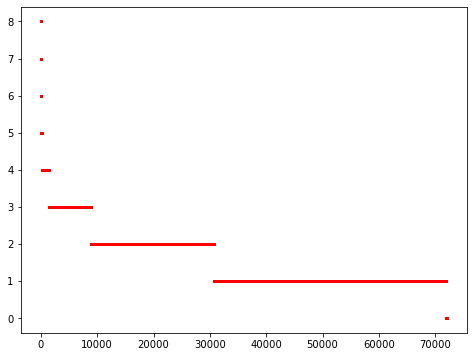

In [71]:
# Figure showing number of polygons

fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(list(gdf_tracts_split["num_poly"].sort_values(ascending=False)), 'ro', ms=2)
plt.show()

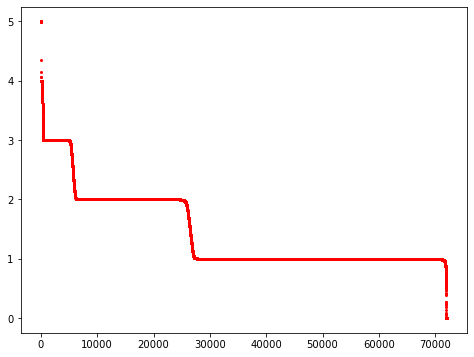

In [72]:
## Figure showing number of times tracts being counted

fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(list(gdf_tracts_split["area_sum"].sort_values(ascending=False)), 'ro', ms=2)
plt.show()

In [73]:
## Import 2018 demand data

def convert_float_to_int_str(ID):
    
    try:
        return str(int(ID))
    
    except:
        return ""


ferc_df = pd.read_csv("FERC/form714-database/planning_area_hourly_demand_ferc714.csv", parse_dates=["local_time"])
ferc_df = ferc_df[(ferc_df["local_time"]>="2018-01-01") & (ferc_df["local_time"]<"2019-01-01")]
ferc_df["eia_code"] = ferc_df["eia_code"].apply(lambda x: convert_float_to_int_str(x))

## IDs different for the areas, needed to be renamed
ferc_df.loc[ferc_df["eia_code"]=="229", "eia_code"] = "2775"
ferc_df.loc[ferc_df["eia_code"]=="17690", "eia_code"] = "59504"
ferc_df.loc[ferc_df["respondent_name"]=="PacifiCorp - Part II Sch 2 (East & West combined)", "eia_code"] = "14379"
ferc_df.loc[ferc_df["respondent_name"]=="East Texas Electric Cooperative", "eia_code"] = "18679"

ferc_demand_sum = ferc_df[["demand_mwh", "eia_code"]].groupby("eia_code").sum().reset_index()

In [74]:
## Show intersection of planning geometries and FERC demand areas
pd.set_option("display.max_rows", 101)

display(ferc_df[["respondent_name", "eia_code"]].drop_duplicates().merge(gdf_planning_areas[["NAME", "ID"]],
                                                                 left_on="eia_code", right_on="ID",
                                                                 how="outer"))

pd.reset_option("display.max_rows")

,respondent_name,eia_code,NAME,ID
0,PowerSouth Energy Cooperative (Alabama Electri...,189,POWERSOUTH ENERGY COOPERATIVE,189
1,Alabama Power Company,195,ALABAMA POWER COMPANY,195
2,"Arizona Electric Power Cooperative, Inc.",796,"ARIZONA ELECTRIC POWER COOPERATIVE, INC.",796
3,Arizona Public Service Company,803,ARIZONA PUBLIC SERVICE COMPANY,803
4,"Associated Electric Cooperative, Inc.",924,"ASSOCIATED ELECTRIC COOPERATIVE, INC.",924
5,Avista Corporation,20169,AVISTA CORPORATION,20169
6,Black Hills Corporation,19545,BLACK HILLS CORPORATION,19545
7,"Bonneville Power Administration, USDOE",1738,BONNEVILLE POWER ADMINISTRATION,1738
8,"Buckeye Power, Inc.",7004,"BUCKEYE POWER, INC.",7004
9,California Independent System Operator,2775,CALIFORNIA INDEPENDENT SYSTEM OPERATOR,2775


In [75]:
## Areas in demand dataframe that do not have a shape geometry

(ferc_demand_sum[~ferc_demand_sum["eia_code"].isin(plan_area_list)]
 .merge(ferc_df[["eia_code", "respondent_name"]])
 .drop_duplicates())

,eia_code,demand_mwh,respondent_name
0,13100,11132980.00,Municipal Electric Authority of Georgia
8760,17867,807656.00,City of St. Cloud
17520,19547,7002252.63,"Hawaiian Electric Company, Inc"
26280,3522,1258622.00,"Chugach Electric Association, Inc."


In [76]:
demand_areas_present = ferc_demand_sum[ferc_demand_sum["eia_code"].isin(plan_area_list)]["eia_code"].tolist()
pop_norm_df = pop_norm_df[demand_areas_present]

# Dataframe which shows demand for every census/planning area intersection
demand_tract_planarea = (pop_norm_df
                         .divide(pop_norm_df.sum())
                         .multiply(pd.Series(ferc_demand_sum[ferc_demand_sum["eia_code"]
                                                             .isin(demand_areas_present)]
                                             .set_index("eia_code")
                                             .to_dict()["demand_mwh"])))

In [77]:
## Dataframe with 2018 demand for each FIPS
tracts_demand = demand_tract_planarea.sum(axis=1).reset_index()
tracts_demand.columns = ["FIPS", "Demand"]

## Geodataframe with 2018 demand for each FIPS
tracts_demand = gdf[["FIPS", "geometry"]].merge(tracts_demand)
tracts_demand = tracts_demand.merge(gdf[["FIPS", "STATE_FIPS", "CNTY_FIPS", "STCOFIPS", "POPULATION", "SQMI"]])

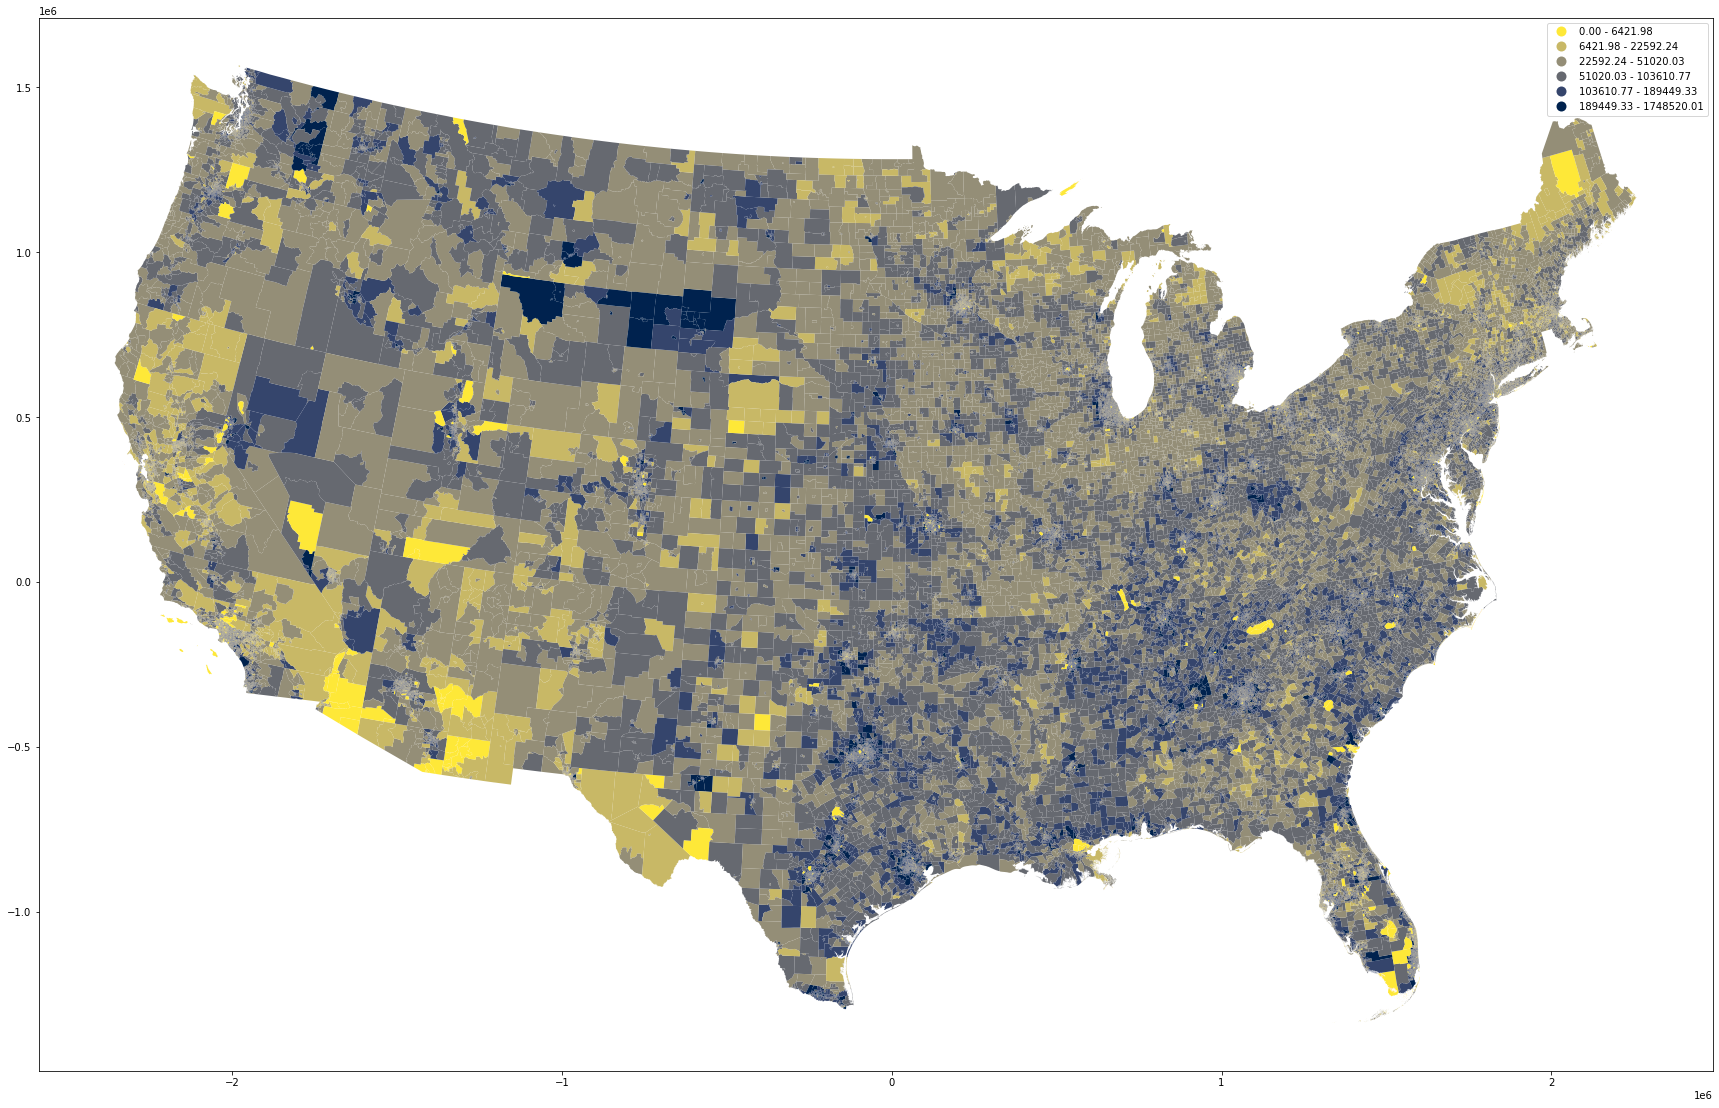

In [78]:
fig, ax = plt.subplots(figsize=(30, 20))
tracts_demand.plot(column="Demand", cmap="cividis_r", legend=True, scheme="percentiles", ax=ax)
plt.show()

In [79]:
## Created tracts demand aggregated by county
county_tracts_demand = tracts_demand[["STCOFIPS",
                                      "geometry"]].merge(tracts_demand
                                                         .groupby("STCOFIPS").sum()
                                                         .reset_index()[["STCOFIPS", "Demand",
                                                                         "SQMI", "POPULATION"]])

county_tracts_demand["energy_demand_per_sqmi"] = county_tracts_demand.apply(lambda x: x["Demand"] / x["SQMI"],
                                                                            axis=1)

county_tracts_demand["demand_per_capita"] = county_tracts_demand.apply(lambda x: x["Demand"] /
                                                                     x["POPULATION"], axis=1)


## Created tracts demand aggregated by state
state_tracts_demand = tracts_demand[["STATE_FIPS",
                                     "geometry"]].merge(tracts_demand
                                                        .groupby("STATE_FIPS").sum()
                                                        .reset_index()[["STATE_FIPS", "Demand",
                                                                        "SQMI", "POPULATION"]])

state_tracts_demand["energy_demand_per_sqmi"] = state_tracts_demand.apply(lambda x: x["Demand"] / x["SQMI"],
                                                                            axis=1)

state_tracts_demand["demand_per_capita"] = state_tracts_demand.apply(lambda x: x["Demand"] /
                                                                     x["POPULATION"], axis=1)

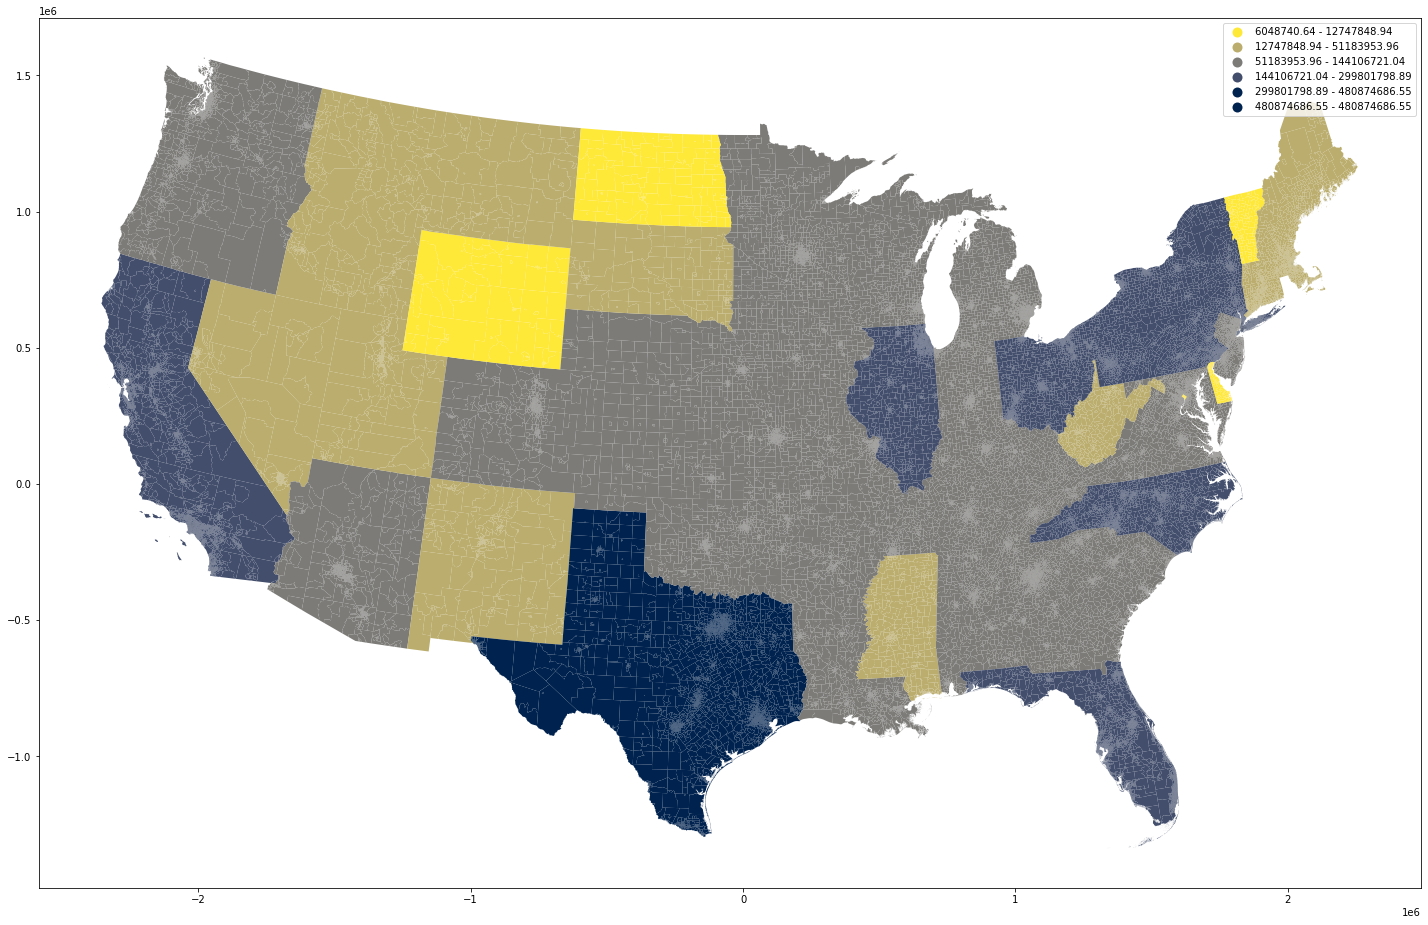

In [80]:
## State demand figure
fig, ax = plt.subplots(figsize=(28, 16))
state_tracts_demand.plot(column="Demand", cmap="cividis_r", ax=ax, legend=True, scheme="percentiles")
plt.show()

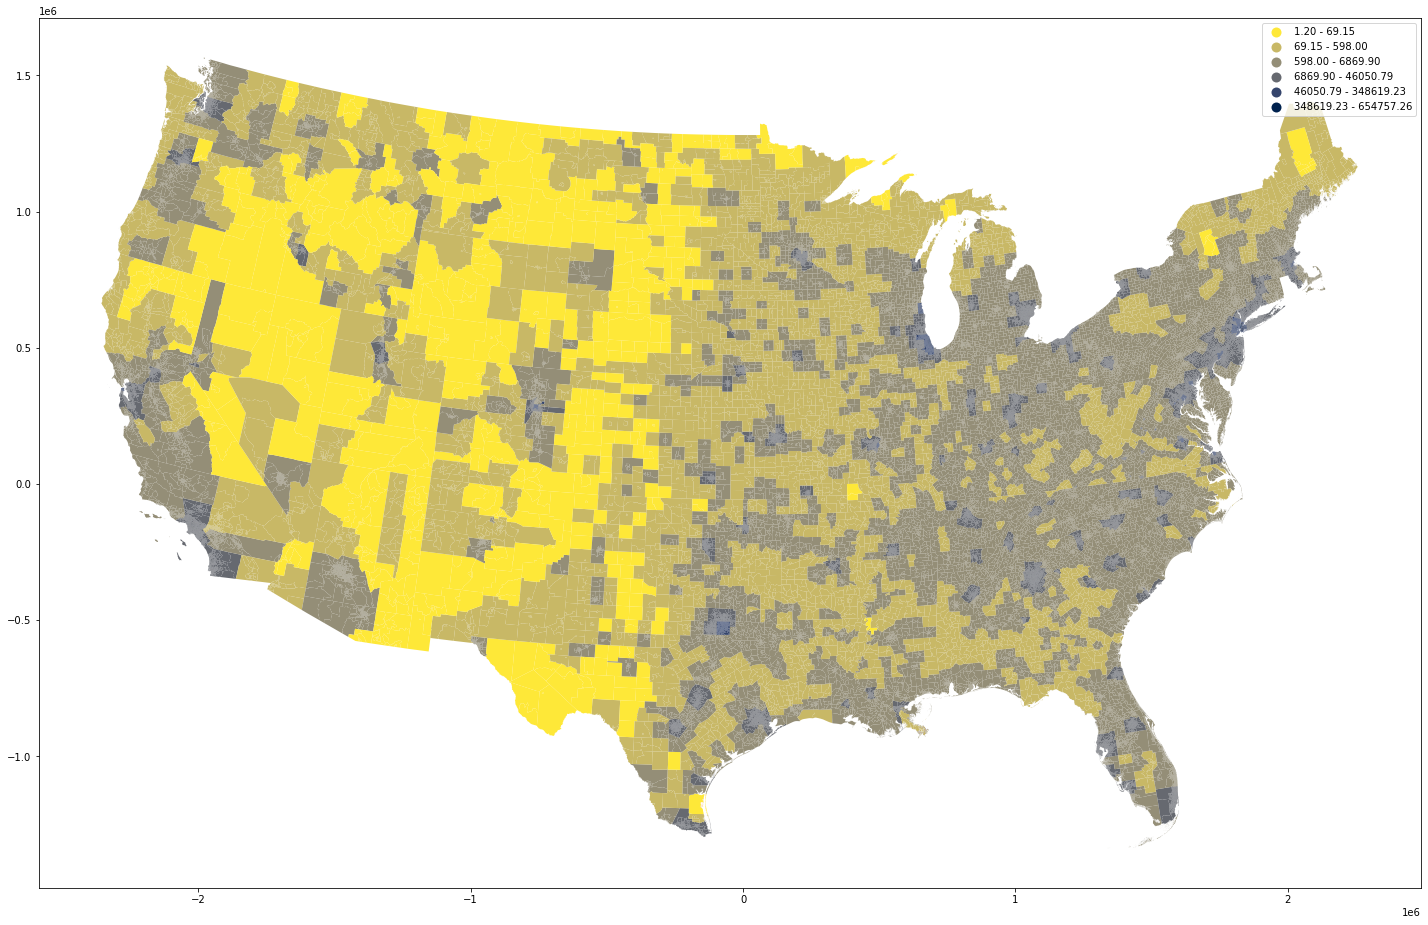

In [81]:
## County demand per unit area
fig, ax = plt.subplots(figsize=(28, 16))
county_tracts_demand.plot(column="energy_demand_per_sqmi", cmap="cividis_r", ax=ax,
                          legend=True, scheme="percentiles")
plt.show()

In [82]:
## Verifying state energy sales

sales_df = pd.read_excel("EIA/sales_annual.xlsx", skiprows=[0])
sales_df = sales_df[sales_df["Year"]==2018]
sales_df = sales_df[~sales_df["State"].isin(["US", "HI", "AK", "DC"])]
print(sales_df["Industry Sector Category"].unique())
sales_df = sales_df[sales_df["Industry Sector Category"]=="Total Electric Industry"]

states_fips_lookup = pd.read_html("https://www.nrcs.usda.gov/wps/portal/nrcs/detail/?cid=nrcs143_013696")[0].iloc[:-1]
states_fips_lookup["FIPS"] = states_fips_lookup["FIPS"].apply(lambda x: int(x))

sales_df = sales_df.merge(states_fips_lookup, left_on="State",
                          right_on="Postal Code")[["State", "Total", "FIPS",
                                                   "Residential", "Commercial", "Industrial"]]

sales_df = (state_tracts_demand[["STATE_FIPS", "Demand"]]
            .drop_duplicates()
            .reset_index(drop=True)
            .merge(sales_df, left_on="STATE_FIPS", right_on="FIPS")).drop("FIPS", axis=1)

sales_df = sales_df.sort_values("Demand", ascending=False).reset_index(drop=True)

sales_df["pc_error"] = sales_df.apply(lambda x: abs(x["Total"] - x["Demand"]) / x["Total"], axis=1)
sales_df = sales_df.sort_values("pc_error", ascending=False).reset_index(drop=True)
sales_df.head()

['Total Electric Industry' 'Full-Service Providers'
 'Energy-Only Providers']


,STATE_FIPS,Demand,State,Total,Residential,Commercial,Industrial,pc_error
0,31,5.442649e+07,NE,30939492,10412008,9553396,10974088,0.759127
1,46,2.134579e+07,SD,12856938,5018360,4903243,2935335,0.660255
2,20,6.637959e+07,KS,42036979,14187192,16168750,11681037,0.579076
3,30,2.266471e+07,MT,14838845,5197686,4921231,4719928,0.527391
4,34,1.153194e+08,NJ,76016762,29530689,38807065,7369106,0.517027


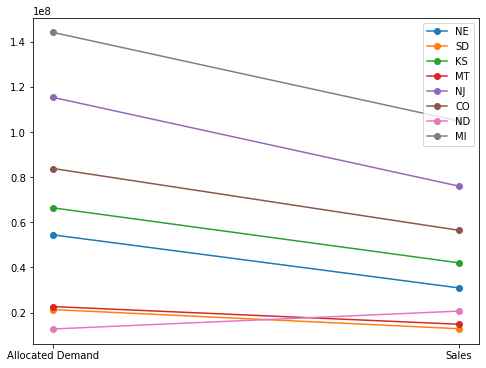

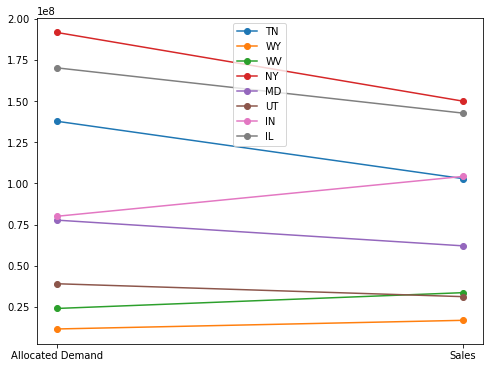

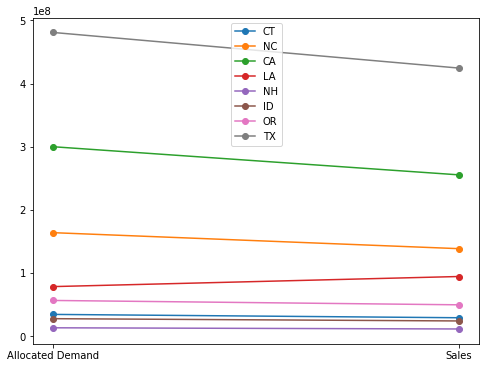

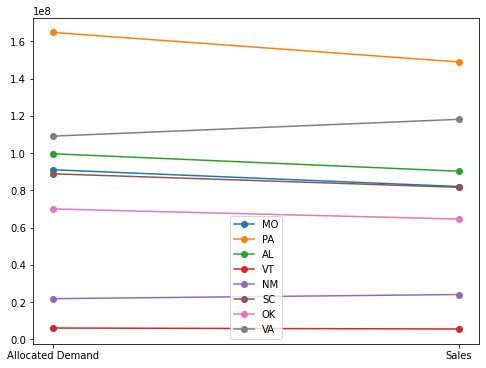

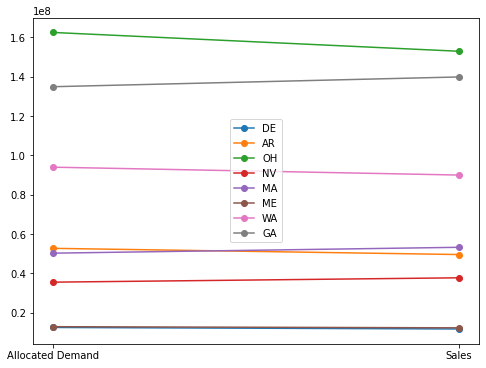

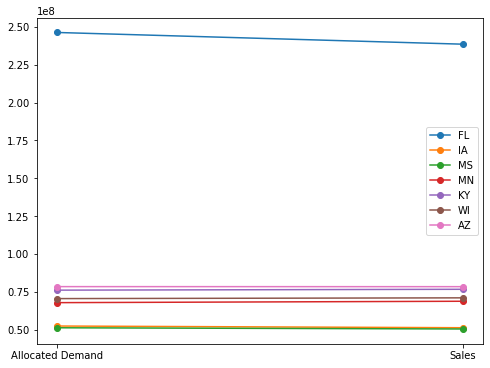

In [83]:
# 6 figures of 8 states with allocated demand and FERC sales

for i in range(6):

    fig, ax = plt.subplots(figsize=(8, 6))

    for idx, row in sales_df.iloc[8*i: 8*(i+1)].iterrows():

        ax.plot([row["Demand"], row["Total"]], marker="o", label=row["State"])
        
    plt.xticks([0, 1], ["Allocated Demand", "Sales"])
    plt.legend()    
    plt.show()
    

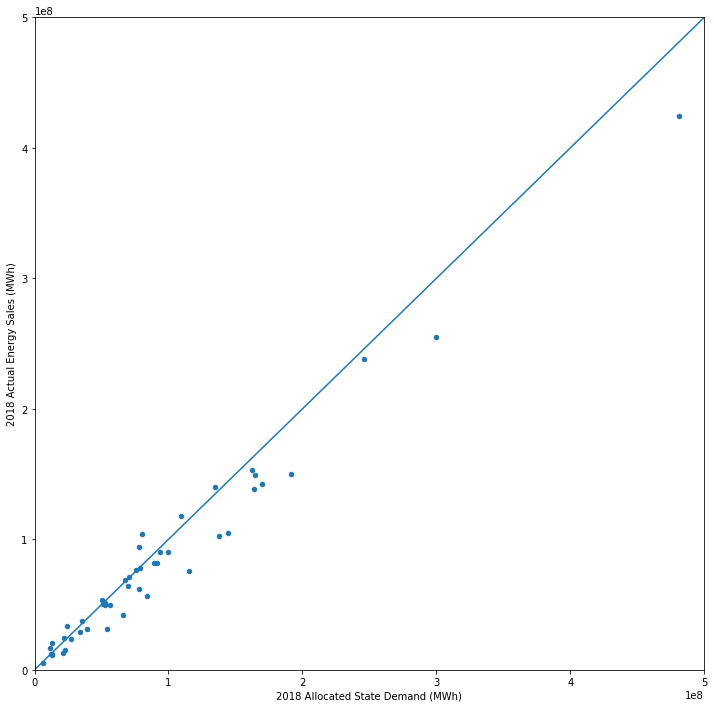

In [84]:
##

fig, ax = plt.subplots(figsize=(12, 12))
sales_df.set_index("State").plot.scatter("Demand", "Total", ax=ax)

ax.plot([0, 5e8], [0, 5e8])

ax.set_xlim(0, 5e8)
ax.set_ylim(0, 5e8)

plt.xlabel("2018 Allocated State Demand (MWh)")
plt.ylabel("2018 Actual Energy Sales (MWh)")

plt.show()